<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>

In [1]:
try:
    # if using Colab
    import google.colab
    is_colab = True
    wdir = 'https://raw.githubusercontent.com/ruggieris/DD/main/'
    # create folder src if it does not exists
    !mkdir -p src
    # download source
    !wget --no-cache --backups=1 -O src/dd.py {wdir}'src/dd.py'
    # required modules
    !pip install pyroaring
    !pip install pyfim 
    !pip install lightgbm
    !pip install fairlearn
except:
    is_colab = False
    wdir = '../' # local files
print('Working dir: ', wdir)

Working dir:  ../


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('src/' if is_colab else '../src/') # local path
import dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Part I: independence metrics

In [3]:
# Sample data: credit.csv, adult.csv or any other dataset with discrete columns only.
df = pd.read_csv(wdir+'data/credit_discrete.csv', sep=',', na_values='?')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,lt_0,le_17d6,critical_or_other_existing_credit,radio_or_tv,le_38848d8,no_known_savings,ge_7,gt_2d8,male_single,none,...,real_estate,gt_52d6,none,own,from_1d6_le_2d2,skilled,le_1d2,yes,no,good
1,from_0_lt_200,gt_31d2,existing_paid,radio_or_tv,from_38848d8_le_7519d6,lt_100,from_1_lt_4,from_1d6_le_2d2,female_div_or_dep_or_mar,none,...,real_estate,le_30d2,none,own,le_1d6,skilled,le_1d2,none,no,bad
2,no_checking,le_17d6,critical_or_other_existing_credit,education,le_38848d8,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,none,...,real_estate,from_41d4_le_52d6,none,own,le_1d6,unskilled_resident,gt_1d2,none,no,good
3,lt_0,gt_31d2,existing_paid,furniture_or_equipment,from_7519d6_le_11154d4,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,guarantor,...,life_insurance,from_41d4_le_52d6,none,for_free,le_1d6,skilled,gt_1d2,none,no,good
4,lt_0,from_17d6_le_31d2,delayed_previously,new_car,from_38848d8_le_7519d6,lt_100,from_1_lt_4,gt_2d8,male_single,none,...,no_known_property,gt_52d6,none,for_free,from_1d6_le_2d2,skilled,gt_1d2,none,no,bad


In [4]:
# DD(filename or dataframe, unprotected item, negative decision)
# age=from_41d4_le_52d6 vs each other age group
disc = dd.DD(df, unprotectedItem='age=from_41d4_le_52d6', predBadItem='class=bad') 
# or 
# disc = dd.DD(df, 'foreign_worker=no', 'class=bad')
'''
     contingency table for independence
     =========== pred.bad === pred.good === 
     protected       a            b       n1()
     unprotected     c            d       n2()
     ===========    m1()  ===    m2()  ==  n()
'''
# global contingency tables
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("RD = {:f}".format(ctg.rd()))
ctg = disc.ctg_any()
disc.print(ctg)
print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 1000  Perc = 100.00%
                     |class=bad|class=good|   
age=gt_52d6          |       29|        67| 96
age=from_41d4_le_52d6|       39|       122|161
                     |       68|       189|257
RD = 0.059847
-----
Context ALL
Size = 1000  Perc = 100.00%
                     |class=bad|class=good|   
age=le_30d2          |      148|       263|411
age=from_41d4_le_52d6|       39|       122|161
                     |      187|       385|572
RD = 0.117861
-----
Context ALL
Size = 1000  Perc = 100.00%
                     |class=bad|class=good|   
age=from_30d2_le_41d4|       84|       248|332
age=from_41d4_le_52d6|       39|       122|161
                     |      123|       370|493
RD = 0.010776
-----
Context ALL
Size = 1000  Perc = 100.00%
                      |class=bad|class=good|    
age!=from_41d4_le_52d6|      261|       578| 839
age=from_41d4_le_52d6 |       39|       122| 161
                      |      300|       700|1000
RD = 0.068849


In [5]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for independence
     =========== pred.bad === pred.good === 
     protected       a            b       n1()
     unprotected     c            d       n2()
     ===========    m1()  ===    m2()  ==  n()
'''
def check_rd(ctg):
    # at least 20 protected with pred.bad and at least one unprotected with pred.bad
    if ctg.a < 20 or ctg.c==0:
        return None
    return ctg.rd()

def check_rr(ctg):
    # at least 20 protected with pred.bad and at least one unprotected with pred.bad
    if ctg.a < 20 or ctg.c==0:
        return None
    return ctg.rr()

In [6]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# topk = keep only top k contingency tables w.r.t. RD
ctgs_rd = disc.extract(testCond=check_rd, minSupp=-20, topk=1000)

In [7]:
# print top 3 contingency tables w.r.t. RD
for v, ctg in ctgs_rd[:3]:
    disc.print(ctg)
    print("RD = {:f}".format(v))

-----
Context duration=gt_31d2 AND existing_credits=from_1d6_le_2d2 AND foreign_worker=no
Size = 60  Perc = 6.00%
                     |class=bad|class=good|  
age=le_30d2          |       21|         6|27
age=from_41d4_le_52d6|        1|         4| 5
                     |       22|        10|32
RD = 0.577778
-----
Context duration=gt_31d2 AND existing_credits=from_1d6_le_2d2
Size = 60  Perc = 6.00%
                     |class=bad|class=good|  
age=le_30d2          |       21|         6|27
age=from_41d4_le_52d6|        1|         4| 5
                     |       22|        10|32
RD = 0.577778
-----
Context purpose=new_car AND personal_status=female_div_or_dep_or_mar AND credit_amount=le_38848d8 AND foreign_worker=no
Size = 57  Perc = 5.70%
                     |class=bad|class=good|  
age=le_30d2          |       20|         8|28
age=from_41d4_le_52d6|        1|         4| 5
                     |       21|        12|33
RD = 0.514286


In [8]:
# contingency tables w.r.t. RR
ctgs_rr = disc.extract(testCond=check_rr, minSupp=-20, topk=1000)
# print top 3 contingency tables w.r.t. RD
for v, ctg in ctgs_rr[:3]:
    disc.print(ctg)
    print("RR = {:f}".format(v))

-----
Context residence_since=gt_2d8 AND job=skilled AND credit_amount=le_38848d8 AND other_payment_plans=none
Size = 225  Perc = 22.50%
                     |class=bad|class=good|   
age=le_30d2          |       29|        57| 86
age=from_41d4_le_52d6|        1|        35| 36
                     |       30|        92|122
RR = 12.139535
-----
Context residence_since=gt_2d8 AND job=skilled AND installment_commitment=gt_2d8 AND credit_amount=le_38848d8 AND other_payment_plans=none
Size = 164  Perc = 16.40%
                     |class=bad|class=good|  
age=le_30d2          |       23|        31|54
age=from_41d4_le_52d6|        1|        27|28
                     |       24|        58|82
RR = 11.925926
-----
Context residence_since=gt_2d8 AND job=skilled AND credit_amount=le_38848d8 AND other_payment_plans=none AND foreign_worker=no
Size = 218  Perc = 21.80%
                     |class=bad|class=good|   
age=le_30d2          |       29|        55| 84
age=from_41d4_le_52d6|        1|     

In [9]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg for _, ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg for _, ctg in ctgs_rr)
# contingency tables in both
shared = ct_rd_set & ct_rr_set
len(shared) 

415

Text(0, 0.5, 'p2')

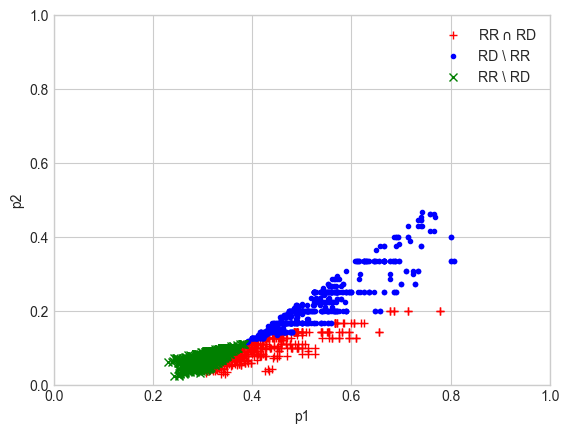

In [10]:
# plot p1() vs p2()
plt.style.use('seaborn-v0_8-whitegrid')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')

In [11]:
# sequential covering algorithm using 10 contingency tables
covers, residuals, times, uncovered, ctg, ctg_rem = disc.cover_n(ct_rd_set, check_rd, 10)
print('Total protected covered:', sum(residuals))
print('Total protected:', sum(residuals)+len(uncovered))
print('% covered: {:.2f}%'.format(100*sum(residuals)/(sum(residuals)+len(uncovered))))
disc.print(ctg)
print("RD for covered = {:f}".format(ctg.rd()))
disc.print(ctg_rem)
print("RD for uncovered = {:f}".format(ctg_rem.rd()))
for ctg, res in zip(covers, residuals):
    print('-----\nCovered', res)
    disc.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

Total protected covered: 263
Total protected: 839
% covered: 31.35%
-----
Context <extensional>
Size = 467  Perc = 46.70%
                      |class=bad|class=good|   
age!=from_41d4_le_52d6|      148|       272|420
age=from_41d4_le_52d6 |        7|        40| 47
                      |      155|       312|467
RD for covered = 0.203445
-----
Context <extensional>
Size = 533  Perc = 53.30%
                      |class=bad|class=good|   
age!=from_41d4_le_52d6|      113|       306|419
age=from_41d4_le_52d6 |       32|        82|114
                      |      145|       388|533
RD for uncovered = -0.011012
-----
Covered 27
-----
Context duration=gt_31d2 AND existing_credits=from_1d6_le_2d2 AND foreign_worker=no
Size = 60  Perc = 6.00%
                     |class=bad|class=good|  
age=le_30d2          |       21|         6|27
age=from_41d4_le_52d6|        1|         4| 5
                     |       22|        10|32
RD = 0.577778
-----
Covered 28
-----
Context purpose=new_car AND perso

# Part II

In [12]:
# Adult dataset
adult = pd.read_csv(wdir+'data/adult_discrete.csv', sep=',', na_values='?')
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,(33.5-41.5],State-gov,(-inf-106068.5],Bachelors,(10.5-13.5],Never-married,Adm-clerical,Not-in-family,White,Male,(57-3368],(-inf-77.5],(39.5-40.5],United-States,-50K
1,(41.5-50.5],Self-emp-not-inc,(-inf-106068.5],Bachelors,(10.5-13.5],Married-civ-spouse,Exec-managerial,Husband,White,Male,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K
2,(33.5-41.5],Private,(196318-260259.5],HS-grad,(8.5-9.5],Divorced,Handlers-cleaners,Not-in-family,White,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K
3,(50.5-inf),Private,(196318-260259.5],11th,(-inf-8.5],Married-civ-spouse,Handlers-cleaners,Husband,NonWhite,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K
4,(25.5-33.5],Private,(260259.5-inf),Bachelors,(10.5-13.5],Married-civ-spouse,Prof-specialty,Wife,NonWhite,Female,(-inf-57],(-inf-77.5],(39.5-40.5],Cuba,-50K


In [13]:
# Encode categorical values
enc = dd.Encode()
df = enc.fit_transform(adult)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,2,6.0,0,9,1,4,0.0,1,1,1,3,0,2,38.0,1
1,3,5.0,0,9,1,2,3.0,0,1,1,0,0,0,38.0,1
2,2,3.0,3,11,3,0,5.0,1,1,1,0,0,2,38.0,1
3,4,3.0,3,1,0,2,5.0,0,0,1,0,0,2,38.0,1
4,1,3.0,4,9,1,2,9.0,5,0,0,0,0,2,4.0,1


In [14]:
# there are missing values (but LightGBM deal with them! no need for imputation methods)
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

In [15]:
# df has categorical features (but LightGBM deal with them! no need for one-hot encoding)
df.dtypes

age               category
workclass         category
fnlwgt            category
education         category
education-num     category
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain      category
capital-loss      category
hours-per-week    category
native-country    category
class             category
dtype: object

In [16]:
# split train test
X = df[df.columns.drop('class')]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, adult_train, adult_test = train_test_split(X, y, adult.copy(), test_size=0.33, random_state=42)

In [17]:
# training model and make predictions 
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
adult_test['predicted'] = [enc.decode['class'][v] for v in clf.predict(X_test)]
adult_test['predicted'].astype('category')
# add predicted score in the adult_test
adult_test['score'] = clf.predict_proba(X_test)[:,1]
adult_test.head()

[LightGBM] [Info] Number of positive: 24951, number of negative: 7773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 32724, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.762468 -> initscore=1.166258
[LightGBM] [Info] Start training from score 1.166258


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,predicted,score
7762,(-inf-25.5],Private,(260259.5-inf),HS-grad,(8.5-9.5],Never-married,Other-service,Not-in-family,White,Male,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K,0.997945
23881,(-inf-25.5],Private,(157936.5-196318],12th,(-inf-8.5],Never-married,Sales,Own-child,White,Female,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K,0.997234
30507,(-inf-25.5],Local-gov,(260259.5-inf),HS-grad,(8.5-9.5],Never-married,Handlers-cleaners,Other-relative,NonWhite,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K,-50K,0.996690
28911,(-inf-25.5],Private,(196318-260259.5],Some-college,(9.5-10.5],Never-married,Sales,Own-child,White,Female,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K,0.997988
19484,(41.5-50.5],Private,(196318-260259.5],HS-grad,(8.5-9.5],Never-married,Machine-op-inspct,Unmarried,NonWhite,Male,(-inf-57],(-inf-77.5],(50.5-inf),Puerto-Rico,-50K,-50K,0.980876


In [18]:
# discrimination in overall test set
atts = list(set(adult_test.columns)-set(['score'])) # do not use score in contexts
disc = dd.DD(adult_test[atts], unprotectedItem='race=White', predBadItem='predicted=-50K', codes=dict(),
                                                 trueBadItem='class=-50K', na_values={'nan'}) 
'''
     contingency table for separation
          protected                                   unprotected
     ========== pred.bad == pred.good ===     === pred.bad   == pred.good === 
     true.bad    TPp          FNp      Pp()          TPu          FNu        Pu()
     true.good   FPp          TNp      Np()          FPu          TNu        Nu()
     ==========   a     =====  b  ===  n1()   ===      c    ====    d   ===  n2()
'''
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("TNR White = {:f}".format(ctg.tnru()))
    print("TNR NonWhite = {:f}".format(ctg.tnrp()))
    print("EOP = {:f}".format(ctg.eop()))

-----
Context ALL
Size = 16118  Perc = 100.00%
race=NonWhite                                      race=White
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          1895|            75| 1970     class=-50K|          9542|           692|10234
class=+50K|           155|           205|  360     class=+50K|          1333|          2221| 3554
          |          2050|           280| 2330               |         10875|          2913|13788
TNR White = 0.624930
TNR NonWhite = 0.569444
EOP = 0.055485


In [19]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for separation
          protected                                   unprotected
     ========== pred.bad == pred.good ===     === pred.bad   == pred.good === 
     true.bad    TPp          FNp      Pp()          TPu          FNu        Pu()
     true.good   FPp          TNp      Np()          FPu          TNu        Nu()
     ==========   a     =====  b  ===  n1()   ===      c    ====    d   ===  n2()
'''
def check_eop(ctg):
    # at least 20 protected with pred.pos and p2() > 0
    if ctg.Pu() < 20 or ctg.Pp() < 20 or ctg.Np()==0 or ctg.Nu()==0:
        return None
    return ctg.eop()

In [20]:
# Extract contingency tables: 
ctgs_eop = disc.extract(testCond=check_eop, minSupp=-100, topk=1000)

In [21]:
# output top 3
for v, ctg in ctgs_eop[:3]:
    disc.print(ctg)
    print("TNR White = {:f}".format(ctg.tnru()))
    print("TNR NonWhite = {:f}".format(ctg.tnrp()))
    print("EOP = {:f}".format(v))

-----
Context marital-status=Married-spouse-absent AND sex=Female AND capital-gain=(-inf-57]
Size = 107  Perc = 0.66%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            36|             0| 36     class=-50K|            66|             1| 67
class=+50K|             3|             0|  3     class=+50K|             0|             1|  1
          |            39|             0| 39               |            66|             2| 68
TNR White = 1.000000
TNR NonWhite = 0.000000
EOP = 1.000000
-----
Context education=10th AND sex=Female AND education-num=(-inf-8.5]
Size = 137  Perc = 0.85%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            29|             0| 29     class=-50K|           106|             0|106
class=+50K|             1|             0

In [22]:
# sequential covering algorithm: 10 contingency tables
covers, residuals, times, uncovered, ctg, ctg_rem = disc.cover_n([ctg for _,ctg in ctgs_eop], check_eop, 10)
print('Total protected covered:', sum(residuals))
print('Total protected:', sum(residuals)+len(uncovered))
print('% covered: {:.2f}%'.format(100*sum(residuals)/(sum(residuals)+len(uncovered))))
disc.print(ctg)
print("EOP in covered = {:f}".format(ctg.eop()))
disc.print(ctg_rem)
print("EOP in uncovered = {:f}".format(ctg_rem.eop()))

for ctg, res in zip(covers, residuals):
    print('-----\nCovered', res)
    disc.print(ctg)
    print("TPR White = {:f}".format(ctg.tnru()))
    print("TPR NonWhite = {:f}".format(ctg.tnrp()))
    print("EOP = {:f}".format(ctg.eop()))

Total protected covered: 366
Total protected: 2330
% covered: 15.71%
-----
Context <extensional>
Size = 1424  Perc = 8.83%
race!=White                                       race=White
          |predicted=-50K|predicted=+50K|                   |predicted=-50K|predicted=+50K|    
class=-50K|           351|             1| 352     class=-50K|          1044|             1|1045
class=+50K|            14|             0|  14     class=+50K|             0|            13|  13
          |           365|             1| 366               |          1044|            14|1058
EOP in covered = 1.000000
-----
Context <extensional>
Size = 14694  Perc = 91.17%
race!=White                                        race=White
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          1544|            74| 1618     class=-50K|          8498|           691| 9189
class=+50K|           141|           205|  346     class=+50K|          1333|          2208|

In [23]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_negative_rate_parity", prefit=True, predict_method='predict')
X_train = X_train.fillna(0) # fairlearn does not manage missing values
X_test = X_test.fillna(0) # fairlearn does not manage missing values
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['race'])
# fair-corrected predictions 
adult_test['predicted'] = [enc.decode['class'][v] for v in postprocess_est.predict(X_test, sensitive_features=X_test['race']).astype(int)]
adult_test['predicted'].astype('category')

7762     -50K
23881    -50K
30507    -50K
28911    -50K
19484    -50K
         ... 
15968    +50K
37984    +50K
31513    -50K
46024    -50K
2946     -50K
Name: predicted, Length: 16118, dtype: category
Categories (2, object): ['+50K', '-50K']

In [24]:
# discrimination in test set
disc = dd.DD(adult_test[atts], unprotectedItem='race=White', predBadItem='predicted=-50K', codes=dict(),
                                                 trueBadItem='class=-50K', na_values={'nan'}) 
'''
     contingency table for separation
          protected                                   unprotected
     ========== pred.bad == pred.good ===     === pred.bad   == pred.good === 
     true.bad    TPp          FNp      Pp()          TPu          FNu        Pu()
     true.good   FPp          TNp      Np()          FPu          TNu        Nu()
     ==========   a     =====  b  ===  n1()   ===      c    ====    d   ===  n2()
'''
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("TNR Male = {:f}".format(ctg.tnru()))
    print("TNR Female = {:f}".format(ctg.tnrp()))
    print("EOP = {:f}".format(ctg.eop()))

-----
Context ALL
Size = 16118  Perc = 100.00%
race=NonWhite                                      race=White
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          1881|            89| 1970     class=-50K|          9503|           731|10234
class=+50K|           153|           207|  360     class=+50K|          1434|          2120| 3554
          |          2034|           296| 2330               |         10937|          2851|13788
TNR Male = 0.596511
TNR Female = 0.575000
EOP = 0.021511


In [25]:
# Extract contingency tables: 
ctgs_eop_post = disc.extract(testCond=check_eop, minSupp=-100, topk=1000)
'''
     contingency table for separation
          protected                                   unprotected
     ========== pred.bad == pred.good ===     === pred.bad   == pred.good === 
     true.bad    TPp          FNp      Pp()          TPu          FNu        Pu()
     true.good   FPp          TNp      Np()          FPu          TNu        Nu()
     ==========   a     =====  b  ===  n1()   ===      c    ====    d   ===  n2()
'''
for v, ctg in ctgs_eop_post[:3]:
    disc.print(ctg)
    print("TNR White = {:f}".format(ctg.tnru()))
    print("TNR NonWhite = {:f}".format(ctg.tnrp()))
    print("EOP = {:f}".format(v))

-----
Context marital-status=Married-spouse-absent AND sex=Female AND capital-gain=(-inf-57]
Size = 107  Perc = 0.66%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            36|             0| 36     class=-50K|            65|             2| 67
class=+50K|             3|             0|  3     class=+50K|             0|             1|  1
          |            39|             0| 39               |            65|             3| 68
TNR White = 1.000000
TNR NonWhite = 0.000000
EOP = 1.000000
-----
Context education=10th AND sex=Female AND education-num=(-inf-8.5]
Size = 137  Perc = 0.85%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            29|             0| 29     class=-50K|           106|             0|106
class=+50K|             1|             0

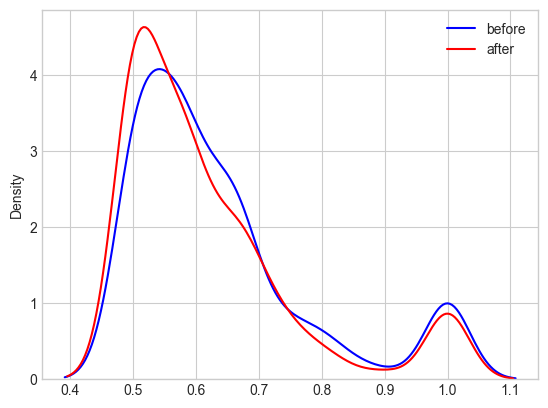

In [26]:
sns.set_style('whitegrid')
sns.kdeplot(np.array([v for v, _ in ctgs_eop]), bw_adjust=1.0, color='b')
sns.kdeplot(np.array([v for v, _ in ctgs_eop_post]), bw_adjust=1.0, color='r')
plt.legend(labels=['before', 'after'])

In [27]:
# sequential covering algorithm: 10 contingency tables
covers, residuals, times, uncovered, ctg, ctg_rem = disc.cover_n([ctg for _,ctg in ctgs_eop_post], check_eop, 10)
print('Total protected covered:', sum(residuals))
print('Total protected:', sum(residuals)+len(uncovered))
print('% covered: {:.2f}%'.format(100*sum(residuals)/(sum(residuals)+len(uncovered))))
disc.print(ctg)
print("EOP in covered = {:f}".format(ctg.eop()))
disc.print(ctg_rem)
print("EOP in uncovered = {:f}".format(ctg_rem.eop()))

for ctg, res in zip(covers, residuals):
    print('-----\nCovered', res)
    disc.print(ctg)
    print("TNR White = {:f}".format(ctg.tnru()))
    print("TNR NonWhite = {:f}".format(ctg.tnrp()))
    print("EOP = {:f}".format(ctg.eop()))

Total protected covered: 369
Total protected: 2330
% covered: 15.84%
-----
Context <extensional>
Size = 1531  Perc = 9.50%
race!=White                                       race=White
          |predicted=-50K|predicted=+50K|                   |predicted=-50K|predicted=+50K|    
class=-50K|           353|             2| 355     class=-50K|          1149|             2|1151
class=+50K|            14|             0|  14     class=+50K|             0|            11|  11
          |           367|             2| 369               |          1149|            13|1162
EOP in covered = 1.000000
-----
Context <extensional>
Size = 14587  Perc = 90.50%
race!=White                                        race=White
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          1528|            87| 1615     class=-50K|          8354|           729| 9083
class=+50K|           139|           207|  346     class=+50K|          1434|          2109|

# Part III

In [28]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     confusion matrix
     =========== pred.bad === pred.good === 
     true.bad        a            b       n1()
     true.good        c            d       n2()
     ===========    m1()  ===    m2()  ==  n()
'''
def check_err(ctg):
    return (ctg.b+ctg.c)/ctg.n()

In [29]:
# errors in test set
disc = dd.DD(adult_test, unprotectedItem='class=-50K', predBadItem='predicted=+50K', codes=dict(), na_values={'nan'}) 
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("ERR = {:f}".format(check_err(ctg)))

-----
Context ALL
Size = 16118  Perc = 100.00%
          |predicted=+50K|predicted=-50K|     
class=+50K|          2327|          1587| 3914
class=-50K|           820|         11384|12204
          |          3147|         12971|16118
ERR = 0.149336


In [30]:
# Extract contingency tables: 
ctgs_err = disc.extract(testCond=check_err, minSupp=-100, topk=1000)

In [31]:
# Top 3
for v, ctg in ctgs_err[:3]:
    disc.print(ctg)
    print("ERR = {:f}".format(check_err(ctg)))

-----
Context occupation=nan AND marital-status=Married-civ-spouse AND hours-per-week=(39.5-40.5] AND native-country=United-States AND capital-loss=(-inf-77.5]
Size = 104  Perc = 0.65%
          |predicted=+50K|predicted=-50K|   
class=+50K|            24|             6| 30
class=-50K|            51|            23| 74
          |            75|            29|104
ERR = 0.548077
-----
Context workclass=nan AND marital-status=Married-civ-spouse AND hours-per-week=(39.5-40.5] AND native-country=United-States AND capital-loss=(-inf-77.5] AND occupation=nan
Size = 104  Perc = 0.65%
          |predicted=+50K|predicted=-50K|   
class=+50K|            24|             6| 30
class=-50K|            51|            23| 74
          |            75|            29|104
ERR = 0.548077
-----
Context workclass=nan AND marital-status=Married-civ-spouse AND hours-per-week=(39.5-40.5] AND native-country=United-States AND capital-loss=(-inf-77.5]
Size = 104  Perc = 0.65%
          |predicted=+50K|predicted=-5

In [32]:
def check_err2(ctg):
    n = ctg.n()
    return (ctg.b+ctg.c)/n if n>100 else None

covers, residuals, times, uncovered, ctg, ctg_rem = disc.cover_n([ctg for _,ctg in ctgs_err], check_err2, 10)
print('Total protected covered:', sum(residuals))
print('Total protected:', sum(residuals)+len(uncovered))
print('% covered: {:.2f}%'.format(100*sum(residuals)/(sum(residuals)+len(uncovered))))
disc.print(ctg)
print("ERR = {:f}".format(check_err(ctg)))
disc.print(ctg_rem)
print("ERR = {:f}".format(check_err(ctg_rem)))
for ctg, res in zip(covers, residuals):
    print(res)
    disc.print(ctg)
    print("ERR = {:f}".format(check_err(ctg)))

Total protected covered: 503
Total protected: 3914
% covered: 12.85%
-----
Context <extensional>
Size = 1040  Perc = 6.45%
           |predicted=+50K|predicted=-50K|    
class!=-50K|           300|           203| 503
class=-50K |           261|           276| 537
           |           561|           479|1040
ERR = 0.446154
-----
Context <extensional>
Size = 15078  Perc = 93.55%
           |predicted=+50K|predicted=-50K|     
class!=-50K|          2027|          1384| 3411
class=-50K |           559|         11108|11667
           |          2586|         12492|15078
ERR = 0.128863
30
-----
Context occupation=nan AND marital-status=Married-civ-spouse AND hours-per-week=(39.5-40.5] AND native-country=United-States AND capital-loss=(-inf-77.5]
Size = 104  Perc = 0.65%
          |predicted=+50K|predicted=-50K|   
class=+50K|            24|             6| 30
class=-50K|            51|            23| 74
          |            75|            29|104
ERR = 0.548077
45
-----
Context age=(41.5-5

# Part IV

In [33]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for inference (protected=None, n1=a,n2=c)
     ===========
     true.pos      a             
     true.neg      c             
     ===========   m1()
'''
def check_acc(ctg):
    n = ctg.m1()
    return max(ctg.a,ctg.c)/n if n>0 else None

In [34]:
# accuracy in training set
disc = dd.DD(adult_train, 'class=-50K', codes=dict(), na_values={'nan'}) 
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("ACC = {:f}".format(check_acc(ctg)))

-----
Context ALL
Size = 32724  Perc = 100.00%
          |     
class=+50K| 7773
class=-50K|24951
          |32724
ACC = 0.762468


In [35]:
# Extract contingency tables: 
ctgs_acc = disc.extract(testCond=check_acc, minSupp=-1000, topk=1000)

In [36]:
for v, ctg in ctgs_acc[:3]:
    disc.print(ctg)
    print("ACC = {:f}".format(check_acc(ctg)))

-----
Context relationship=Own-child AND hours-per-week=(-inf-35.5] AND sex=Female AND race=White AND native-country=United-States AND capital-gain=(-inf-57]
Size = 1003  Perc = 3.07%
          |    
class=+50K|   0
class=-50K|1003
          |1003
ACC = 1.000000
-----
Context relationship=Own-child AND hours-per-week=(-inf-35.5] AND sex=Female AND race=White AND capital-gain=(-inf-57] AND capital-loss=(-inf-77.5]
Size = 1000  Perc = 3.06%
          |    
class=+50K|   0
class=-50K|1000
          |1000
ACC = 1.000000
-----
Context relationship=Own-child AND hours-per-week=(-inf-35.5] AND sex=Female AND race=White AND capital-gain=(-inf-57]
Size = 1027  Perc = 3.14%
          |    
class=+50K|   0
class=-50K|1027
          |1027
ACC = 1.000000


<Axes: ylabel='Density'>

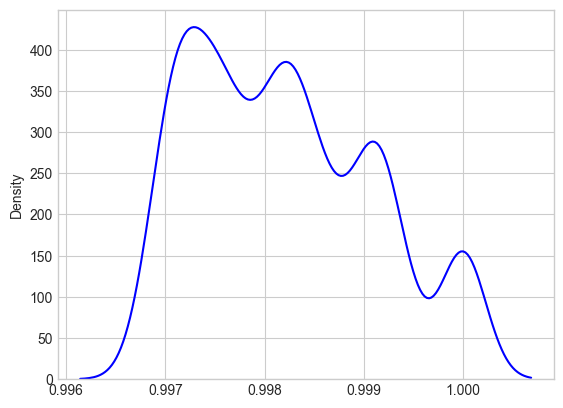

In [37]:
# TBD: boundary kernel limiting to (0.0, 1.0)
sns.kdeplot(np.array([v for v, _ in ctgs_acc]), bw_adjust=1.0, color='b')